# OLS on Basic Variable Set

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
#from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
from reed import *
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
import pickle
import time
import statsmodels.api as sm
from direct_regression import plot_ate_distribution


# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
%matplotlib inline

%load_ext autoreload
%autoreload 2

sklearn.__version__

'1.0.1'

#### Select modeling parameters

In [3]:
outcome = 'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=True
standardize_outcome=True
config_name = "default"
data_file = "data/basic_variables.csv"
test = False

In [4]:
# parameters that depend on those set above (which may have been inserted by Papermill)
if test:
    inner_cv = 2
    outer_cv = 2
    bootstrap_samples = 3

else:
    inner_cv = 5
    outer_cv = 10
    bootstrap_samples = 1000

### Load Data 
   - drop rows missing the specified treatment or outcome

Dropped 284 rows missing treatment or outcome.


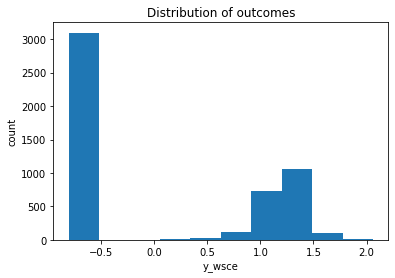

In [5]:
data = pd.read_csv(data_file,index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    shift = 1 - data[outcome].min() # to ensure log is defined
    data[outcome] = np.log(data[outcome]+shift)
if standardize_outcome:
    mu, std = data[outcome].mean(), data[outcome].std()
    data[outcome] = (data[outcome]-mu)/std
    
plt.hist(data[outcome])
plt.xlabel(outcome)
plt.ylabel("count")
plt.title("Distribution of outcomes");

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [6]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)
print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)

Control data dimensions:  (3789, 21)
Treated data dimensions: (1368, 21)


### Compute unconditional/unadjusted estimate of treatment effect

In [7]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:27%
Average outcome under Control:-0.14±0.02
Average outcome under Treatment:0.37±0.03
Unadjusted treatment estimate 0.51


### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [8]:
from sklearn.linear_model import LinearRegression
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('OLS',LinearRegression(),importance_func=importance_from_coef)
    ]
    return models

In [9]:
from direct_regression import nested_cross_val
models0, models1, results = nested_cross_val(
    construct_models,
    None,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=inner_cv,
    outercv=outer_cv,
    load_from_cache=False)

Fitting OLS ...Done


### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
OLS,0.07,0.01,0.40,0.04,0.23,0.08,-0.55,0.04,-0.77,0.09


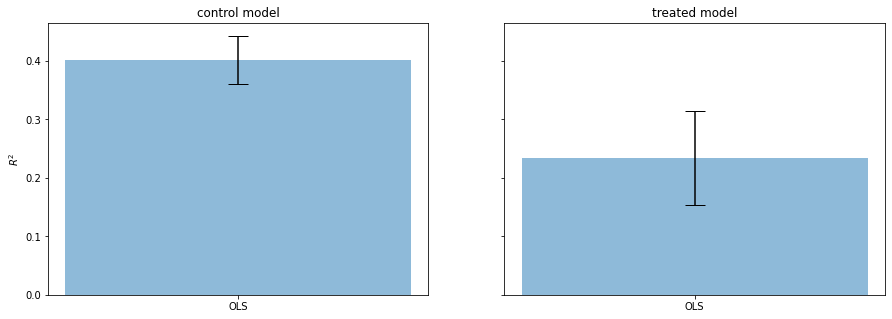

In [10]:
from direct_regression import visualise_ate
visualise_ate(results,X,evaluation_metrics);

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models

In [11]:
from direct_regression import display_feature_importance
display_feature_importance(models0, models1, results, features);

OLS


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
"ahgage_(54, 120]",0.599304,0.007809,-0.087989,0.015792,-0.643299,0.011414,-0.555310,0.010787
"ahgage_(44, 54]",0.488678,0.008408,0.032448,0.014048,-0.472454,0.009905,-0.504902,0.011914
aesdtl_3.0,0.193775,0.008679,-0.064984,0.015682,-0.226268,0.014538,-0.161283,0.007891
"ahgage_(34, 44]",0.108580,0.006895,-0.086374,0.013652,-0.151767,0.007060,-0.065394,0.011766
aedhigh1_9.0,0.091958,0.011680,-0.056488,0.017448,-0.120201,0.016385,-0.063714,0.012514
aesdtl_2.0,0.057927,0.007128,0.006141,0.019165,-0.054856,0.014912,-0.060997,0.007931
interact_ahgsex_2.0_aesdtl_3.0,0.051212,0.011249,0.098037,0.021262,0.094250,0.020963,-0.003787,0.008898
interact_ahgsex_2.0_aesdtl_2.0,0.042325,0.009150,0.022038,0.020971,0.053344,0.017197,0.031306,0.009570
aedhigh1_8.0,0.035265,0.007948,-0.049766,0.012104,-0.059821,0.013153,-0.010055,0.007286


### What are the major confounders

  - We want to identify variables that strongly effect both treatment and outcome
   
For each variable Z, in the covariate set lets compute $E[Z|T=1] - E[Z|T=0]$

In [12]:
Xt = np.hstack((t.reshape(-1,1),X))
model = LinearRegression()
model.fit(Xt,y)
beta = model.coef_[1:]

confound = pd.DataFrame({'response_coef':beta, 'treatment_inf':X1.mean(axis=0) - X0.mean(axis=0)},index=features)
confound['confound'] = np.abs(confound['response_coef'])*np.abs(confound['treatment_inf'])
confound.sort_values(by='confound',ascending=False)

,response_coef,treatment_inf,confound
"ahgage_(54, 120]",-0.566447,-0.574540,0.325446
"ahgage_(44, 54]",-0.500919,-0.116053,0.058133
aesdtl_3.0,-0.171162,-0.291709,0.049930
"ahgage_(34, 44]",-0.093369,0.252289,0.023556
aedhigh1_9.0,-0.071854,-0.283646,0.020381
"interact_ahgsex_2.0_ahgage_(54, 120]",0.034125,-0.405574,0.013840
"interact_ahgsex_2.0_ahgage_(34, 44]",-0.029871,0.261578,0.007814
aesdtl_2.0,-0.059711,0.091144,0.005442
interact_ahgsex_2.0_aesdtl_2.0,0.040172,0.135050,0.005425
interact_ahgsex_2.0_aesdtl_3.0,0.019563,-0.177558,0.003474


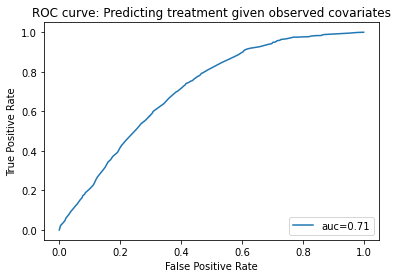

In [13]:
p_model = LogisticRegression()
p_model.fit(X,t)
p_model.coef_
p = p_model.predict_proba(X)[:,1]
from sklearn.metrics import roc_curve, roc_auc_score
auc = roc_auc_score(t,p)
fpr, tpr, _ = roc_curve(t,p)
plt.plot(fpr, tpr,label=f'auc={auc:.2f}')
plt.legend(loc='lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve: Predicting treatment given observed covariates");

In [14]:
from direct_regression import bootstrapped_cross_val
def extract_params(estimator):
    return estimator.coef_


bootstrap_results = bootstrapped_cross_val(
    construct_models,
    None,
    X0, X1, y0, y1,
    optimisation_metric,
    extract_params,
    inner_cv=inner_cv,
    load_from_cache=False,
    samples=bootstrap_samples
)

Fitting OLS ...Done
Total time:3.8970415592193604 seconds


####  Average treatment effect uncertainty via Bootstrapping

,ACE,ACE_std
OLS,0.071428,0.028402


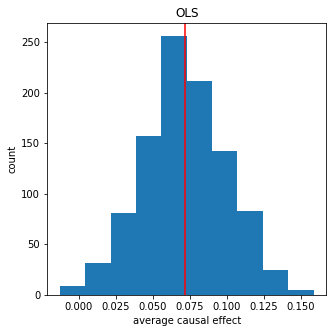

In [15]:
from direct_regression import compute_ate

metrics, tau_estimatesb = compute_ate(bootstrap_results,X)
display(metrics)
plot_ate_distribution(tau_estimatesb)

## Statsmodels

Statsmodels provides a useful comparison, in that it is an independent implementation of OLS and provides theory based confidence intervals and p-values.

### Control Model

In [16]:
x0 = sm.add_constant(X0)
x0 = pd.DataFrame(x0, columns=['intercept']+features)
model0 = sm.OLS(y0,x0)
sm_result = model0.fit()
sm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     126.2
Date:                Tue, 23 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:06:12   Log-Likelihood:                -4216.9
No. Observations:                3789   AIC:                             8478.
Df Residuals:                    3767   BIC:                             8615.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                               -0.0305      0.012     -2.499      0.013      -0.055      -0.007
ahgage_(34, 44]                         -0.0653      0.024     -2.670      0.008      -0.113      -0.017
ahgage_(44, 54]                         -0.5048      0.024    -21.153      0.000      -0.552      -0.458
ahgage_(54, 120]                        -0.5552      0.025    -22.236      0.000      -0.604      -0.506
ahgsex_2.0                              -0.0293      0.049     -0.603      0.546      -0.124       0.066
aedhigh1_3.0                             0.0106      0.024      0.435      0.664      -0.037       0.059
aedhigh1_4.0                            -0.0152      0.023     -0.661      0.509      -0.060       0.030
aedhigh1_5.0                            -0.0104      0.025     -0.425      0.671      -0.059       0.038
aedhigh1_8.0                            -0.0101      0.026     -0.393      0.695      -0.060       0.040
aedhigh1_9.0                            -0.0638      0.031     -2.077      0.038      -0.124      -0.004
aesdtl_2.0                              -0.0610      0.026     -2.370      0.018      -0.112      -0.011
aesdtl_3.0                              -0.1613      0.023     -7.088      0.000      -0.206      -0.117
interact_ahgsex_2.0_ahgage_(34, 44]     -0.0375      0.027     -1.384      0.167      -0.091       0.016
interact_ahgsex_2.0_ahgage_(44, 54]      0.0363      0.026      1.401      0.161      -0.015       0.087
interact_ahgsex_2.0_ahgage_(54, 120]     0.0444      0.027      1.664      0.096      -0.008       0.097
interact_ahgsex_2.0_aedhigh1_3.0         0.0154      0.026      0.586      0.558      -0.036       0.067
interact_ahgsex_2.0_aedhigh1_4.0         0.0243      0.024      1.000      0.317      -0.023       0.072
interact_ahgsex_2.0_aedhigh1_5.0        -0.0075      0.023     -0.331      0.740      -0.052       0.037
interact_ahgsex_2.0_aedhigh1_8.0        -0.0086      0.029     -0.301      0.763      -0.065       0.048
interact_ahgsex_2.0_aedhigh1_9.0        -0.0005      0.039     -0.013      0.989      -0.077       0.076
interact_ahgsex_2.0_aesdtl_2.0           0.0314      0.029      1.087      0.277      -0.025       0.088
interact_ahgsex_2.0_aesdtl_3.0          -0.0037      0.027     -0.136      0.892      -0.057       0.050
==============================================================================
Omnibus:                        4.543   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                4.589
Skew:                          -0.082   Prob(JB):                        0.101
Kurtosis:                       2.955   Cond. No.                         13.0
===============================================================

### Treated Model

In [17]:
x1 = sm.add_constant(X1)
x1 = pd.DataFrame(x1, columns=['intercept']+features)
model1 = sm.OLS(y1,x1)
sm_result = model1.fit()
sm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     22.76
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           3.23e-74
Time:                        12:06:12   Log-Likelihood:                -1746.5
No. Observations:                1368   AIC:                             3537.
Df Residuals:                    1346   BIC:                             3652.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                                0.0413      0.031      1.317      0.188      -0.020       0.103
ahgage_(34, 44]                         -0.1519      0.039     -3.857      0.000      -0.229      -0.075
ahgage_(44, 54]                         -0.4724      0.043    -10.889      0.000      -0.558      -0.387
ahgage_(54, 120]                        -0.6434      0.069     -9.380      0.000      -0.778      -0.509
ahgsex_2.0                              -0.0105      0.073     -0.144      0.885      -0.153       0.132
aedhigh1_3.0                             0.0016      0.043      0.037      0.970      -0.083       0.087
aedhigh1_4.0                             0.0048      0.041      0.118      0.906      -0.076       0.086
aedhigh1_5.0                             0.0439      0.042      1.033      0.302      -0.039       0.127
aedhigh1_8.0                            -0.0599      0.048     -1.237      0.216      -0.155       0.035
aedhigh1_9.0                            -0.1200      0.060     -2.000      0.046      -0.238      -0.002
aesdtl_2.0                              -0.0540      0.059     -0.916      0.360      -0.170       0.062
aesdtl_3.0                              -0.2262      0.057     -3.975      0.000      -0.338      -0.115
interact_ahgsex_2.0_ahgage_(34, 44]     -0.0015      0.041     -0.037      0.971      -0.082       0.079
interact_ahgsex_2.0_ahgage_(44, 54]     -0.0150      0.046     -0.328      0.743      -0.105       0.075
interact_ahgsex_2.0_ahgage_(54, 120]     0.0242      0.074      0.330      0.742      -0.120       0.168
interact_ahgsex_2.0_aedhigh1_3.0        -0.0084      0.044     -0.192      0.847      -0.094       0.077
interact_ahgsex_2.0_aedhigh1_4.0        -0.0231      0.042     -0.555      0.579      -0.105       0.059
interact_ahgsex_2.0_aedhigh1_5.0        -0.0506      0.038     -1.348      0.178      -0.124       0.023
interact_ahgsex_2.0_aedhigh1_8.0         0.0360      0.050      0.714      0.476      -0.063       0.135
interact_ahgsex_2.0_aedhigh1_9.0         0.0178      0.070      0.254      0.800      -0.120       0.155
interact_ahgsex_2.0_aesdtl_2.0           0.0527      0.061      0.868      0.386      -0.066       0.172
interact_ahgsex_2.0_aesdtl_3.0           0.0943      0.061      1.552      0.121      -0.025       0.214
==============================================================================
Omnibus:                      160.753   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.352
Skew:                          -0.454   Prob(JB):                     4.82e-19
Kurtosis:                       2.191   Cond. No.                         10.1
===============================================================

### Fully coupled model
Fit a single model for both treatment and control surfaces with a treatment indicator. 

```{note}
This assumes there is no treatment effect heterogeneity
```

In [18]:
x = np.hstack((t.reshape(-1,1),X))
x = sm.add_constant(x)
x = pd.DataFrame(x, columns=['intercept','treatment']+features)
model = sm.OLS(y,x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     154.7
Date:                Tue, 23 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:06:12   Log-Likelihood:                -6005.5
No. Observations:                5157   AIC:                         1.206e+04
Df Residuals:                    5134   BIC:                         1.221e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
intercept                               -0.0286      0.013     -2.228      0.026      -0.054      -0.003
treatment                                0.1077      0.026      4.156      0.000       0.057       0.158
ahgage_(34, 44]                         -0.0934      0.021     -4.532      0.000      -0.134      -0.053
ahgage_(44, 54]                         -0.5009      0.021    -24.232      0.000      -0.541      -0.460
ahgage_(54, 120]                        -0.5664      0.023    -24.968      0.000      -0.611      -0.522
ahgsex_2.0                              -0.0207      0.040     -0.520      0.603      -0.099       0.057
aedhigh1_3.0                             0.0081      0.021      0.381      0.703      -0.034       0.050
aedhigh1_4.0                            -0.0106      0.020     -0.529      0.597      -0.050       0.029
aedhigh1_5.0                             0.0036      0.021      0.168      0.866      -0.038       0.045
aedhigh1_8.0                            -0.0239      0.023     -1.054      0.292      -0.068       0.021
aedhigh1_9.0                            -0.0719      0.027     -2.655      0.008      -0.125      -0.019
aesdtl_2.0                              -0.0597      0.024     -2.493      0.013      -0.107      -0.013
aesdtl_3.0                              -0.1712      0.021     -7.969      0.000      -0.213      -0.129
interact_ahgsex_2.0_ahgage_(34, 44]     -0.0299      0.022     -1.340      0.180      -0.074       0.014
interact_ahgsex_2.0_ahgage_(44, 54]      0.0215      0.022      0.974      0.330      -0.022       0.065
interact_ahgsex_2.0_ahgage_(54, 120]     0.0341      0.024      1.444      0.149      -0.012       0.080
interact_ahgsex_2.0_aedhigh1_3.0         0.0069      0.022      0.309      0.757      -0.037       0.051
interact_ahgsex_2.0_aedhigh1_4.0         0.0105      0.021      0.505      0.614      -0.030       0.051
interact_ahgsex_2.0_aedhigh1_5.0        -0.0201      0.019     -1.044      0.297      -0.058       0.018
interact_ahgsex_2.0_aedhigh1_8.0         0.0044      0.025      0.177      0.860      -0.044       0.053
interact_ahgsex_2.0_aedhigh1_9.0        -0.0034      0.034     -0.102      0.919      -0.069       0.062
interact_ahgsex_2.0_aesdtl_2.0           0.0402      0.026      1.537      0.124      -0.011       0.091
interact_ahgsex_2.0_aesdtl_3.0           0.0196      0.025      0.781      0.435      -0.030       0.069
==============================================================================
Omnibus:                       71.909   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.129
Skew:                          -0.223   Prob(JB):                     1.19e-14
Kurtosis:                       2.684